# Import libraries

In [1]:
import os
import pandas as pd
import tweepy
import json
import urllib.request
import random 
import numpy as np
import datetime
import warnings
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm


# load json with country names and codes
with urllib.request.urlopen("https://raw.githubusercontent.com/dquintani/GreenhouseData/master/supplemental/STANDARD_COUNTRY_DICT_ISO3.json") as url:
    STANDARD_COUNTRY_DICT = json.loads(url.read().decode())
    
pd.set_option('display.max_colwidth', None)

In [2]:
# environmental secrets when working locally
from dotenv import load_dotenv
try:
    load_dotenv()
    # load_dotenv("../../../../")
    print("envs loaded")
except:
    print("envs failed to load")
    pass

envs loaded


# Create plots

In [3]:
plt.style.use("dark_background")
plt.rcParams['font.family'] = 'Manjari'


In [4]:
# import mau's middleware
df = pd.read_csv("https://raw.githubusercontent.com/mauforonda/super_magic_covid_middleware/master/docs/complete.csv", index_col=0)
df.index = pd.to_datetime(df.index)


# habitantes ine proyeccion 2020: https://www.ine.gob.bo/index.php/censos-y-proyecciones-de-poblacion-sociales/
# habitantes = pd.read_csv("https://raw.githubusercontent.com/dquintani/covid/main/habitantes.csv", index_col=None)

#lista de departamentos
departamentos = list(df.columns)[:-1]
print("departamentos: ", departamentos)

# lista de tipos
tipos = df.tipo.unique()
print("tipos: ", tipos)

df

departamentos:  ['Chuquisaca', 'La Paz', 'Cochabamba', 'Oruro', 'Potosí', 'Tarija', 'Santa Cruz', 'Beni', 'Pando']
tipos:  ['casos' 'decesos' 'positividad' 'pruebas' 'internacion' 'uci' 'uti'
 'primera' 'segunda' 'tercera' 'unica' 'anual']


,Chuquisaca,La Paz,Cochabamba,Oruro,Potosí,Tarija,Santa Cruz,Beni,Pando,tipo
2020-03-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,casos
2020-03-11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,casos
2020-03-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,casos
2020-03-13,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,casos
2020-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,casos
...,...,...,...,...,...,...,...,...,...,...
2022-07-30,233.0,799.0,717.0,141.0,152.0,116.0,564.0,26.0,24.0,anual
2022-07-31,23.0,40.0,184.0,27.0,4.0,22.0,272.0,1.0,1.0,anual
2022-08-01,190.0,504.0,676.0,127.0,130.0,133.0,760.0,36.0,52.0,anual
2022-08-02,146.0,839.0,825.0,195.0,145.0,260.0,794.0,66.0,39.0,anual


In [5]:
def plot_por_departamento(departamento, period_days = 9999, df = df):

    # set up plot
    fig = plt.figure(constrained_layout=False, figsize=(12,10), dpi=200)
    gs = fig.add_gridspec(4, 4)
    fig.suptitle(f"COVID-19  y Vacunación en {departamento}\n\nDatos de los últimos {period_days} dìas", fontsize = 28.7, y=1.01)

    c = {
        "casos": "gold",
        "muertes": "r",
        "positividad" : "g"
    }

    # set axs
    ax_casos = plt.subplot2grid((4, 4), (0,0), colspan=4)

    ax_muertes = plt.subplot2grid((4, 4), (1,0), colspan=2)

    ax_positividad = plt.subplot2grid((4, 4), (1,2), colspan=2)

    ax_hosp = plt.subplot2grid((4, 4), (2,0), colspan=4)

    ax_vac_left = plt.subplot2grid((4, 4), (3,0), colspan=4)

    # ax_vac_right = plt.subplot2grid((4, 4), (3,2), colspan=2)
    # ax_vac_right.set_title("Cobertura de Vacunación")    



    # casos
    df_casos = df[df.tipo=="casos"]
    latest_date = datetime.datetime(df_casos.index[-1].year, df_casos.index[-1].month, df_casos.index[-1].day)
    df_casos = df_casos[df_casos.index >= latest_date - datetime.timedelta(days = period_days-1)]
    
    ax = ax_casos
    ax_casos.set_title("Casos Confirmados de COVID-19" + f" (Última actualización: {latest_date.day}/{latest_date.month})", color = c["casos"])    
    casos = df_casos[departamento]
    colors = cm.YlOrBr_r(casos.values / float(max(casos.values)))
    bar = ax.bar(casos.index, casos, color = colors)
    ax.bar_label(bar, fontsize = 7)
    ax.plot(casos.index, casos.rolling(7).mean(), color="w", lw=3)
    ax.set_ylabel("Casos Confirmados", color = c["casos"])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.set_frame_on(False)
    ax.grid(lw=.3, ls=":")
    ax.annotate(f"Promedio actual:\n{casos.rolling(7).mean()[-1].round(1)} casos/día", 
                xy = (df_casos.index[0],ax.get_ylim()[1]*.7), color = "black", bbox = {"alpha":.75, "facecolor": "gold"})


    # muertes
    df_muertes = df[df.tipo=="decesos"]
    df_muertes = df_muertes[df_muertes.index >= latest_date - datetime.timedelta(days = period_days-1)]
    
    ax = ax_muertes
    ax_muertes.set_title("Muertes Diarias" + f" (Última actualización: {latest_date.day}/{latest_date.month})", color = c["muertes"])    
    bar = ax.bar(df_muertes.index, df_muertes[departamento], color = c["muertes"])
    ax.bar_label(bar, fontsize = 7)
    ax.plot(df_muertes.index, df_muertes[departamento].rolling(7).mean(), color="w")
    ax.set_ylabel("Muertes Diarias", color = c["muertes"])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.set_ylim(0,ax.get_ylim()[1]*1.2)
    ax.set_frame_on(False)
    ax.grid(lw=.3, ls=":")
    ax.annotate(f"Promedio actual:\n{df_muertes[departamento].rolling(7).mean()[-1].round(1)} muertes/día", 
                xy = (df_muertes.index[0],ax.get_ylim()[1]*.7), bbox = {"alpha":.65, "facecolor": "r"})


    # positividad
    df_positividad = df[df.tipo=="positividad"]
    latest_date = datetime.datetime(df_positividad.index[-1].year, df_positividad.index[-1].month, df_positividad.index[-1].day)
    df_positividad = df_positividad[df_positividad.index >= latest_date - datetime.timedelta(days = period_days-1)]   
    
    ax = ax_positividad
    ax_positividad.set_title("Positividad" + f" (Última actualización: {latest_date.day}/{latest_date.month})", color=c["positividad"])
    positividad = df_positividad[departamento].rolling(7).mean().interpolate().dropna()
    colors = cm.Greens(positividad.values / float(max(positividad.values)))
    ax.bar(positividad.index, positividad, color=colors)
    ax.set_ylabel("Positividad", color = c["positividad"])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.set_ylim(0,ax.get_ylim()[1]*1.2)
    ax.set_frame_on(False)
    ax.grid(lw=.2, ls=":")
    posi = positividad[-1].round(1)
    ax.annotate(f"Positividad actual:\n{posi}%", 
                xy = (df_positividad.index[-period_days+5],ax.get_ylim()[1]*.7), bbox = {"alpha":.65, "facecolor": "g"})


    # hosp
    df_hosp = df[df.tipo.isin(["uti", "uci", "internacion"])]
    latest_date = datetime.datetime(df_hosp.index[-1].year, df_hosp.index[-1].month, df_hosp.index[-1].day)
    df_hosp = df_hosp[df_hosp.index >= latest_date - datetime.timedelta(days = period_days-1)]   
    
    ax = ax_hosp
    ax_hosp.set_title("Hospitalizaciones con COVID-19" + f" (Última actualización: {latest_date.day}/{latest_date.month})")    
    internacion = df_hosp[df_hosp.tipo=="internacion"][departamento]
    uti = df_hosp[df_hosp.tipo=="uti"][departamento]
    uci = df_hosp[df_hosp.tipo=="uci"][departamento]
    bar1 = ax.bar(internacion.index, internacion, color="cyan", label="Internación")
    bar2 = ax.bar(uci.index, uci, color="orange", bottom=internacion, label="UCI")
    bar3 = ax.bar(uti.index, uti, color="r", bottom = internacion + uci, label="UTI")
    ax.legend(title="Tipo de hospitalización")
    ax.set_ylabel("Hospitalizados")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.set_ylim(0,ax.get_ylim()[1]*1.2)
    ax.set_frame_on(False)
    ax.grid(lw=.2, ls=":")


    # vacunacion diaria
    df_vac_dia = df[df.tipo.isin(['primera','segunda', 'tercera', 'unica', 'anual'])]
    latest_date = datetime.datetime(df_vac_dia.index[-1].year, df_vac_dia.index[-1].month, df_vac_dia.index[-1].day)
    df_vac_dia = df_vac_dia[df_vac_dia.index >= latest_date - datetime.timedelta(days = period_days-1)]   
   
    ax = ax_vac_left
    ax_vac_left.set_title("Vacunación Diaria" + f" (Última actualización: {latest_date.day}/{latest_date.month})")    
    primera = df_vac_dia[df_vac_dia.tipo=="primera"][departamento]
    segunda = df_vac_dia[df_vac_dia.tipo=="segunda"][departamento]
    tercera = df_vac_dia[df_vac_dia.tipo=="tercera"][departamento]
    unica = df_vac_dia[df_vac_dia.tipo=="unica"][departamento]
    anual = df_vac_dia[df_vac_dia.tipo=="anual"][departamento]
    
    bar1 = ax.bar(primera.index, primera, color="cyan",                                                 label="Primera")
    bar2 = ax.bar(segunda.index, segunda, color="green",  bottom = primera,                             label="Segunda")
    bar3 = ax.bar(tercera.index, tercera, color="r",      bottom = primera + segunda,                   label="Tercera")
    bar4 = ax.bar(unica.index,   unica,   color="m",   bottom = primera + segunda + tercera,         label="Única")
    bar5 = ax.bar(anual.index,   anual,   color="y",      bottom = primera + segunda + tercera + unica, label="Anual")
    ax.legend(title="tipo de dosis:")
    ax.set_ylabel("vacunacionnes")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.set_ylim(0,ax.get_ylim()[1]*1.2)
    ax.set_frame_on(False)
    ax.grid(lw=.2, ls=":")


    # # vacunacion cobertura
    # df_vac_cobertura = df_vac_dia.groupby("tipo").sum()
    # display(df_vac_cobertura)
   
    # ax = ax_vac_right
    # primera = df_vac_dia[df_vac_dia.tipo=="primera"][departamento]
    # segunda = df_vac_dia[df_vac_dia.tipo=="segunda"][departamento]
    # tercera = df_vac_dia[df_vac_dia.tipo=="tercera"][departamento]
    # unica = df_vac_dia[df_vac_dia.tipo=="unica"][departamento]
    # anual = df_vac_dia[df_vac_dia.tipo=="anual"][departamento]
    # bar1 = ax.bar(primera.index, primera, color="cyan",                                                 label="primera")
    # bar2 = ax.bar(segunda.index, segunda, color="orange", bottom = primera,                             label="segunda")
    # bar3 = ax.bar(tercera.index, tercera, color="r",      bottom = primera + segunda,                   label="tercera")
    # bar4 = ax.bar(unica.index,   unica,   color="blue",   bottom = primera + segunda + tercera,         label="unica")
    # bar5 = ax.bar(anual.index,   anual,   color="y",      bottom = primera + segunda + tercera + unica, label="anual")
    # ax.legend(title="tipo de dosis:")
    # ax.set_ylabel("vacunacionnes")
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    # ax.set_ylim(0,ax.get_ylim()[1]*1.2)
    # ax.set_frame_on(False)
    # ax.grid(lw=.2, ls=":")


    fig.tight_layout(pad=2)

    fig.savefig("fig/" + departamento + "_resumen", bbox_inches="tight")

    fig.text(.5, -0.051, "Datos de UPAPE, Ministerio de Salud y RHD vía Mauricio Foronda y Gabriel Eduardo Weiss (Sociedatos)", ha="center", fontsize=16)

    return fig

# GO
# plot_por_departamento(random.choice(departamentos), period_days=random.choice([30, 60, 90]))
pass

# Set up tweepy

In [6]:
# Set up tweepy
#USING GITHUB ENVS

# test
BG1_TWITTER_APIKEY= os.environ["BG1_TWITTER_APIKEY"]
BG1_TWITTER_APIKEYSECRET = os.environ["BG1_TWITTER_APIKEYSECRET"]

BG1_TWITTER_BEARERTOKEN = os.environ["BG1_TWITTER_BEARERTOKEN"]
BG1_TWITTER_ACCESSTOKEN = os.environ["BG1_TWITTER_ACCESSTOKEN"]
BG1_TWITTER_ACCESSTOKENSECRET = os.environ["BG1_TWITTER_ACCESSTOKENSECRET"]

# Authenticate to Twitter
auth = tweepy.OAuthHandler(BG1_TWITTER_APIKEY, BG1_TWITTER_APIKEYSECRET)
auth.set_access_token(BG1_TWITTER_ACCESSTOKEN, BG1_TWITTER_ACCESSTOKENSECRET)

# Create API object 
api = tweepy.API(auth)
api

# Retrieve log

In [7]:
id_log = pd.read_csv("id_log.csv", index_col = 0)
id_log.reply_datetime = pd.to_datetime(id_log.reply_datetime)
id_log

,reply_datetime,username
tweet_id,,
1556630721808179200,2022-08-12 16:36:18.045948,LaRazon_Bolivia
1557933100889509890,2022-08-12 16:41:48.662788,correodelsurcom


# Process:
- find tweets
- filter using log
- create customized message

# Functions

In [8]:
def REPLY_MESSAGE_GENERATOR(departamento):
    
    text1 = ["¿Necesitas datos de COVID-19? ", "¿Buscas datos de COVID-19? "]
    text2 = [f"Tenemos varios para {departamento}. ", f"Tenemos los más importantes para {departamento}. "]

    FINAL_MESSAGE = random.choice(text1) + random.choice(text2) + f"Abajo encontrarás casos confirmados, muertes, positividad de pruebas, hospitalizaciones con prueba positiva de COVID-19, y vacunaciones. Saludos! 🤖"
    
    return FINAL_MESSAGE


###### ------------------ EXAMPLE --------------------------------------

# MESSAGE =  REPLY_MESSAGE_GENERATOR(random.choice(departamentos))
# print(MESSAGE)

¿Buscas datos de COVID-19? Tenemos los más importantes para La Paz. Abajo encontrarás casos confirmados, muertes, positividad de pruebas, hospitalizaciones con prueba positiva de COVID-19, y vacunaciones. Saludos! 🤖


In [9]:
def TWEET_FINDER(message, search_count = 20, result_type = "mixed"):

    print(f" > Searching for {search_count} tweets containing \"{message}\"")
    
    #FIND TWEETS
    tweet_list = api.search_tweets(message,
                                   result_type=result_type,
                                   count=search_count)
    
    print(f" > found {len(tweet_list)} tweets")
    
    # MAKE DF OF TWEETS
    tweet_df = pd.DataFrame(columns=["username",
                                      "followers",
                                      "date",
                                      "time",
                                      "location",
                                      "verified",
                                      # "link_and_id",
                                      "id",
                                      "message",
                                     ])
    for i, j in enumerate(tweet_list):
        tweet_df.loc[i] = [j.user.screen_name, 
                            j.user.followers_count, 
                            j.created_at.date(), 
                            j.created_at.time(), 
                            j.user.location,
                            j.user.verified, 
                            # f"https://twitter.com/twitter/statuses/{j.id}",
                            j.id,
                            api.get_status(j.id, tweet_mode="extended").full_text,
                           ]
        

    #SORT TWEETS BY TIME
    tweet_df.sort_values(["date","time"], ascending=False)
    
    return tweet_df

# ------------------------------------------------------------------------------------------------------------

# tweet_df = TWEET_FINDER(f"{random.choice(departamentos)} covid bolivia", search_count=10, result_type="mixed")
# tweet_df

 > Searching for 10 tweets containing "Potosí covid bolivia"
 > found 1 tweets


,username,followers,date,time,location,verified,id,message
0,ejutv,25737,2022-08-03,19:18:05,Santa Cruz de la Sierra,False,1554909488070725634,"Potosí determina suspender los actos cívicos por el Covid-19\nhttps://t.co/dzXocxeMbz\nVida, Videos ! Coronavirus en Bolivia https://t.co/LyM9msO3Vs"


In [10]:
def TWEET_FILTER(tweet_df, invalidity_period_days = 10, remove_retweets = True):
    
    ###############################
    #      FILTER 1: name log      #
    ################################
    
    # RETRIEVE ID AND NAME LOG
    name_log = id_log.copy()

    # Current time and invalidity date
    now = datetime.datetime.now()
    print(f" > days of invalidity: {invalidity_period_days}")
    invalidity_date = now - datetime.timedelta(days=invalidity_period_days)
    
    #create list of invalid usernames
    name_log_invalid_list = list(name_log[name_log.reply_datetime > invalidity_date].username)
    print(f" > Number of invalids: {len(name_log_invalid_list)}")
    
    # Final filter
    tweet_df_filtered1 = tweet_df[-tweet_df.username.isin(name_log_invalid_list)]
    filter_count = len(tweet_df) - len(tweet_df_filtered1)
    print(f" > {filter_count} usernames filtered out")
    
    
    
    
    
    ###################################
    #    FILTER 2: retweeted tweets   #
    ##################################$
    
    warnings.filterwarnings("ignore")

    #create new df and add "is_a_retweet" columns
    tweet_df_filtered2 = tweet_df_filtered1
    tweet_df_filtered2["is_a_retweet"] = np.nan
        
    for i, j in enumerate(tweet_df_filtered1["id"]):
        
        tweet = api.get_status(j)
        
        try:
            if type(tweet.retweeted_status) == tweepy.models.Status:
                tweet_df_filtered2.loc[:,"is_a_retweet"][i] = True
        except:
            tweet_df_filtered2.loc[:,"is_a_retweet"][i] = False
            
    warnings.filterwarnings("default")
    
    # Filter out tweets that are actually just retweets
    if remove_retweets == True:
        starting = len(tweet_df_filtered2)
        tweet_df_filtered2 = tweet_df_filtered2[tweet_df_filtered2.is_a_retweet==False]
        retweets_removed = starting - len(tweet_df_filtered2)
        print(f" > retweets removed: {retweets_removed}")

    
    return tweet_df_filtered2
    
# ----------------------------------------------------------------------------------------------------------------    

# tweet_df_filtered = TWEET_FILTER(tweet_df, remove_retweets=True)
# tweet_df_filtered

 > days of invalidity: 10
 > Number of invalids: 2
 > 0 usernames filtered out
 > retweets removed: 0


,username,followers,date,time,location,verified,id,message,is_a_retweet
0,ejutv,25737,2022-08-03,19:18:05,Santa Cruz de la Sierra,False,1554909488070725634,"Potosí determina suspender los actos cívicos por el Covid-19\nhttps://t.co/dzXocxeMbz\nVida, Videos ! Coronavirus en Bolivia https://t.co/LyM9msO3Vs",False


In [11]:
def TWEET_SELECTOR(tweet_df_filtered, count, priority, remove_col_value = ["column", "value"], max_followers = None):
    
    SELECTED_TWEETS = []
    df = tweet_df_filtered
    #priority
    if priority == "follower_count":
        df = df.sort_values("followers", ascending=False)
    if priority == "verified":
        df = df.sort_values("verified", ascending=False)
    # display(df)
    
    # remove specific value in a columns?
    if remove_col_value != ["column", "value"]:
        df = df[df[remove_col_value[0]] != remove_col_value[1]]
        print(f"removed [column, value] = {remove_col_value}")
    
    #max followers?
    if max_followers != None:
        df = df[df.followers < max_followers]
        print(f"max followers: {max_followers}")
    
    SELECTED_TWEETS = list(df["id"][:count])
    return SELECTED_TWEETS

# -----------------------------------------------------------------------

# SELECTED_TWEETS = TWEET_SELECTOR(tweet_df_filtered, 
#                count = 3, 
#                priority = "follower_count", 
#                 remove_col_value = ["column", "value"], # default: ["column", "value"]
#                max_followers = 1000000)
# SELECTED_TWEETS

max followers: 1000000


[1554909488070725634]

 > saved and selected 1 images


[1558103673187844102]

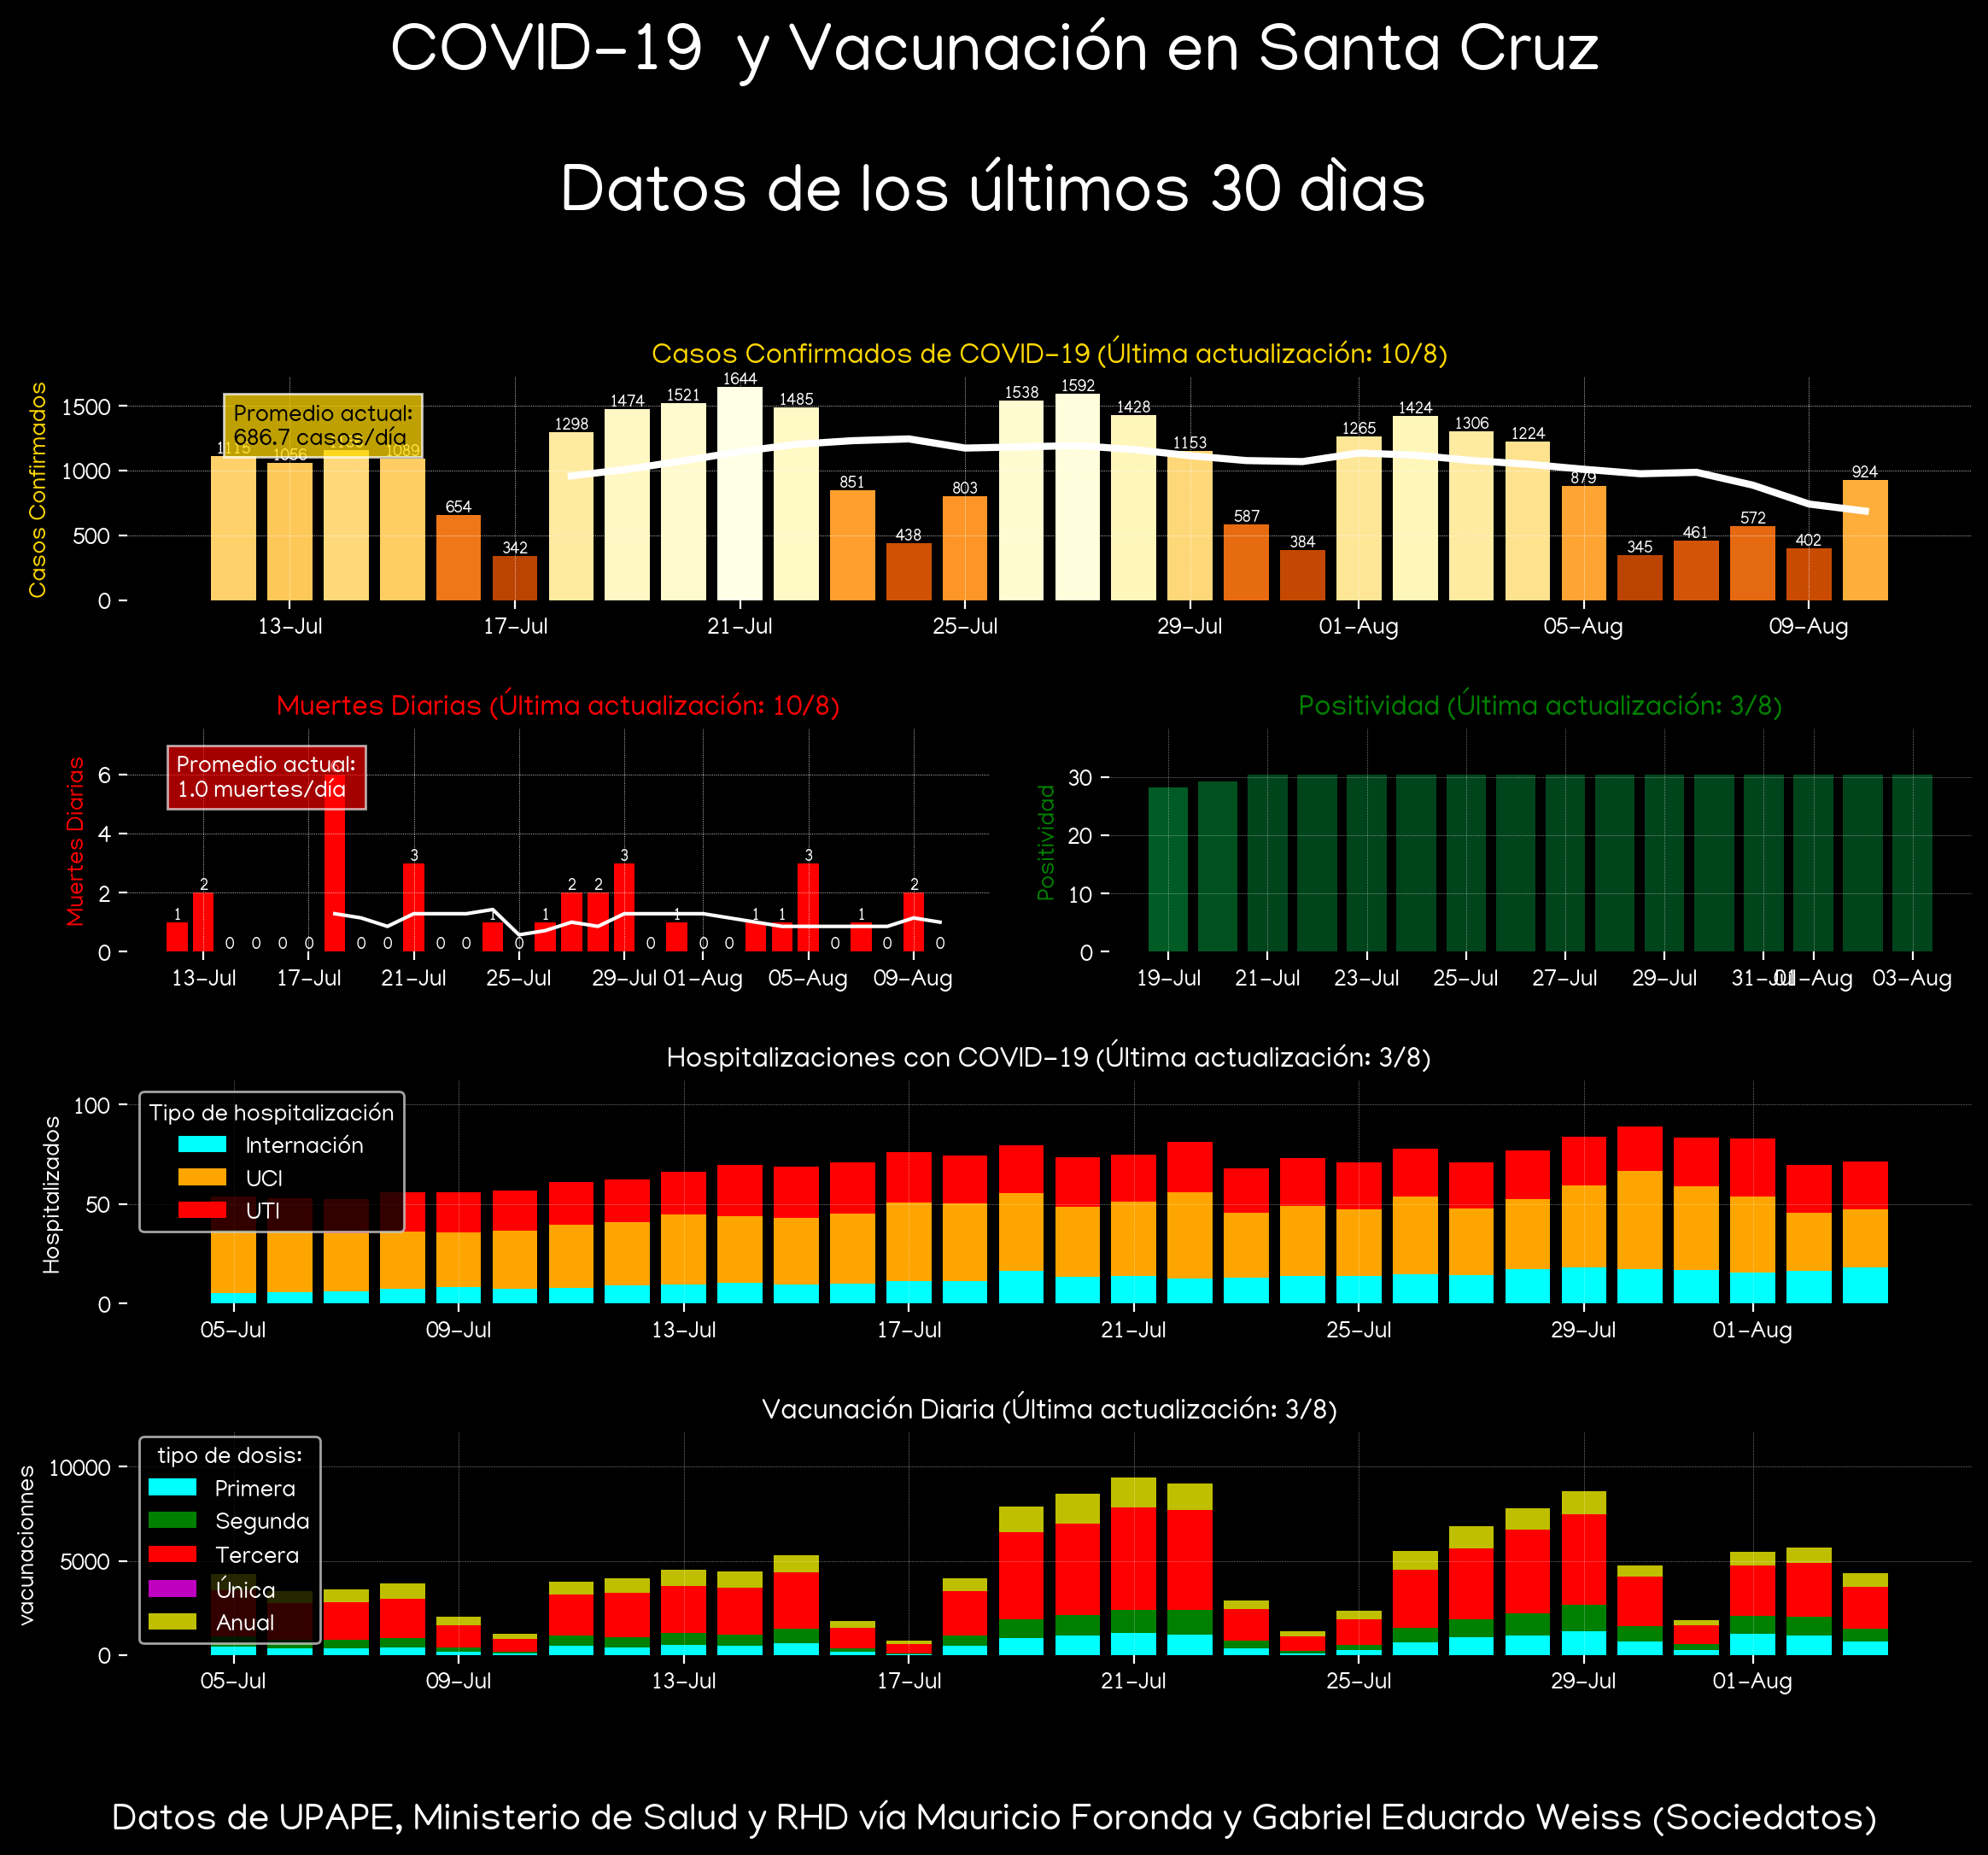

In [12]:
def TWEET_IMAGE_SAVER_AND_SELECTOR(departamento):
    
    plot_por_departamento(departamento, period_days=random.choice([30, 60, 90]))
        
    path = "fig/" + departamento + "_resumen.png"

    media_ids = []
    res = api.media_upload(path)
    media_ids.append(res.media_id)

    print(f" > saved and selected {len(media_ids)} images")
    return media_ids
    
# ---------------------------------------------------------------

# TWEET_IMAGE_SAVER_AND_SELECTOR(random.choice(departamentos))

In [13]:
def TWEET_REPLIER_AND_LOGGER(SELECTED_TWEETS, MESSAGE, media_ids):
    
    if len(SELECTED_TWEETS)>0:
        
        for i,j in enumerate(SELECTED_TWEETS):

            # SEND TWEET
            if len(media_ids)==0:
                medi_ids = None
                
            try:
                api.update_status(status = MESSAGE,
                                 in_reply_to_status_id = j,
                                 auto_populate_reply_metadata=True,
                                 media_ids=media_ids
                                 )

                # LOG TWEET ID (AND THUS USERNAME) and datetime
                id_log.loc[j] = [datetime.datetime.now(), api.get_status(j).user.screen_name]

                SUCCESS = True
                print(" > TWEET SUCCESSFUL!!")
                
            except:
                SUCCESS = False
                print("\n > OH NO! Something sketchy is going on with that username! Nothing tweeted. False.")
        

    if len(SELECTED_TWEETS) == 0:
        print("\n > OH NO! NO TWEETS WERE FOUND NOR TWEETED")
        SUCCESS = False
    # save log
    id_log.to_csv("id_log.csv")
    
    return SUCCESS
    
# -------------------------------------------------



# run!

Starting success list []
MESSAGE:  ¿Necesitas datos de COVID-19? Tenemos los más importantes para Cochabamba. Abajo encontrarás casos confirmados, muertes, positividad de pruebas, hospitalizaciones con prueba positiva de COVID-19, y vacunaciones. Saludos! 🤖
 > Searching for 10 tweets containing "Cochabamba covid bolivia"
 > found 10 tweets
 > days of invalidity: 10
 > Number of invalids: 2
 > 2 usernames filtered out
 > retweets removed: 3
 > saved and selected 1 images
 > TWEET SUCCESSFUL!!


,tweet_id,reply_datetime,username
0,1556630721808179200,2022-08-12 16:36:18.045948,LaRazon_Bolivia
1,1557933100889509890,2022-08-12 16:41:48.662788,correodelsurcom
2,1557575190418178048,2022-08-12 16:50:48.963902,grupoeldeber


success list: [True] 





 FINISHED WHILE LOOP


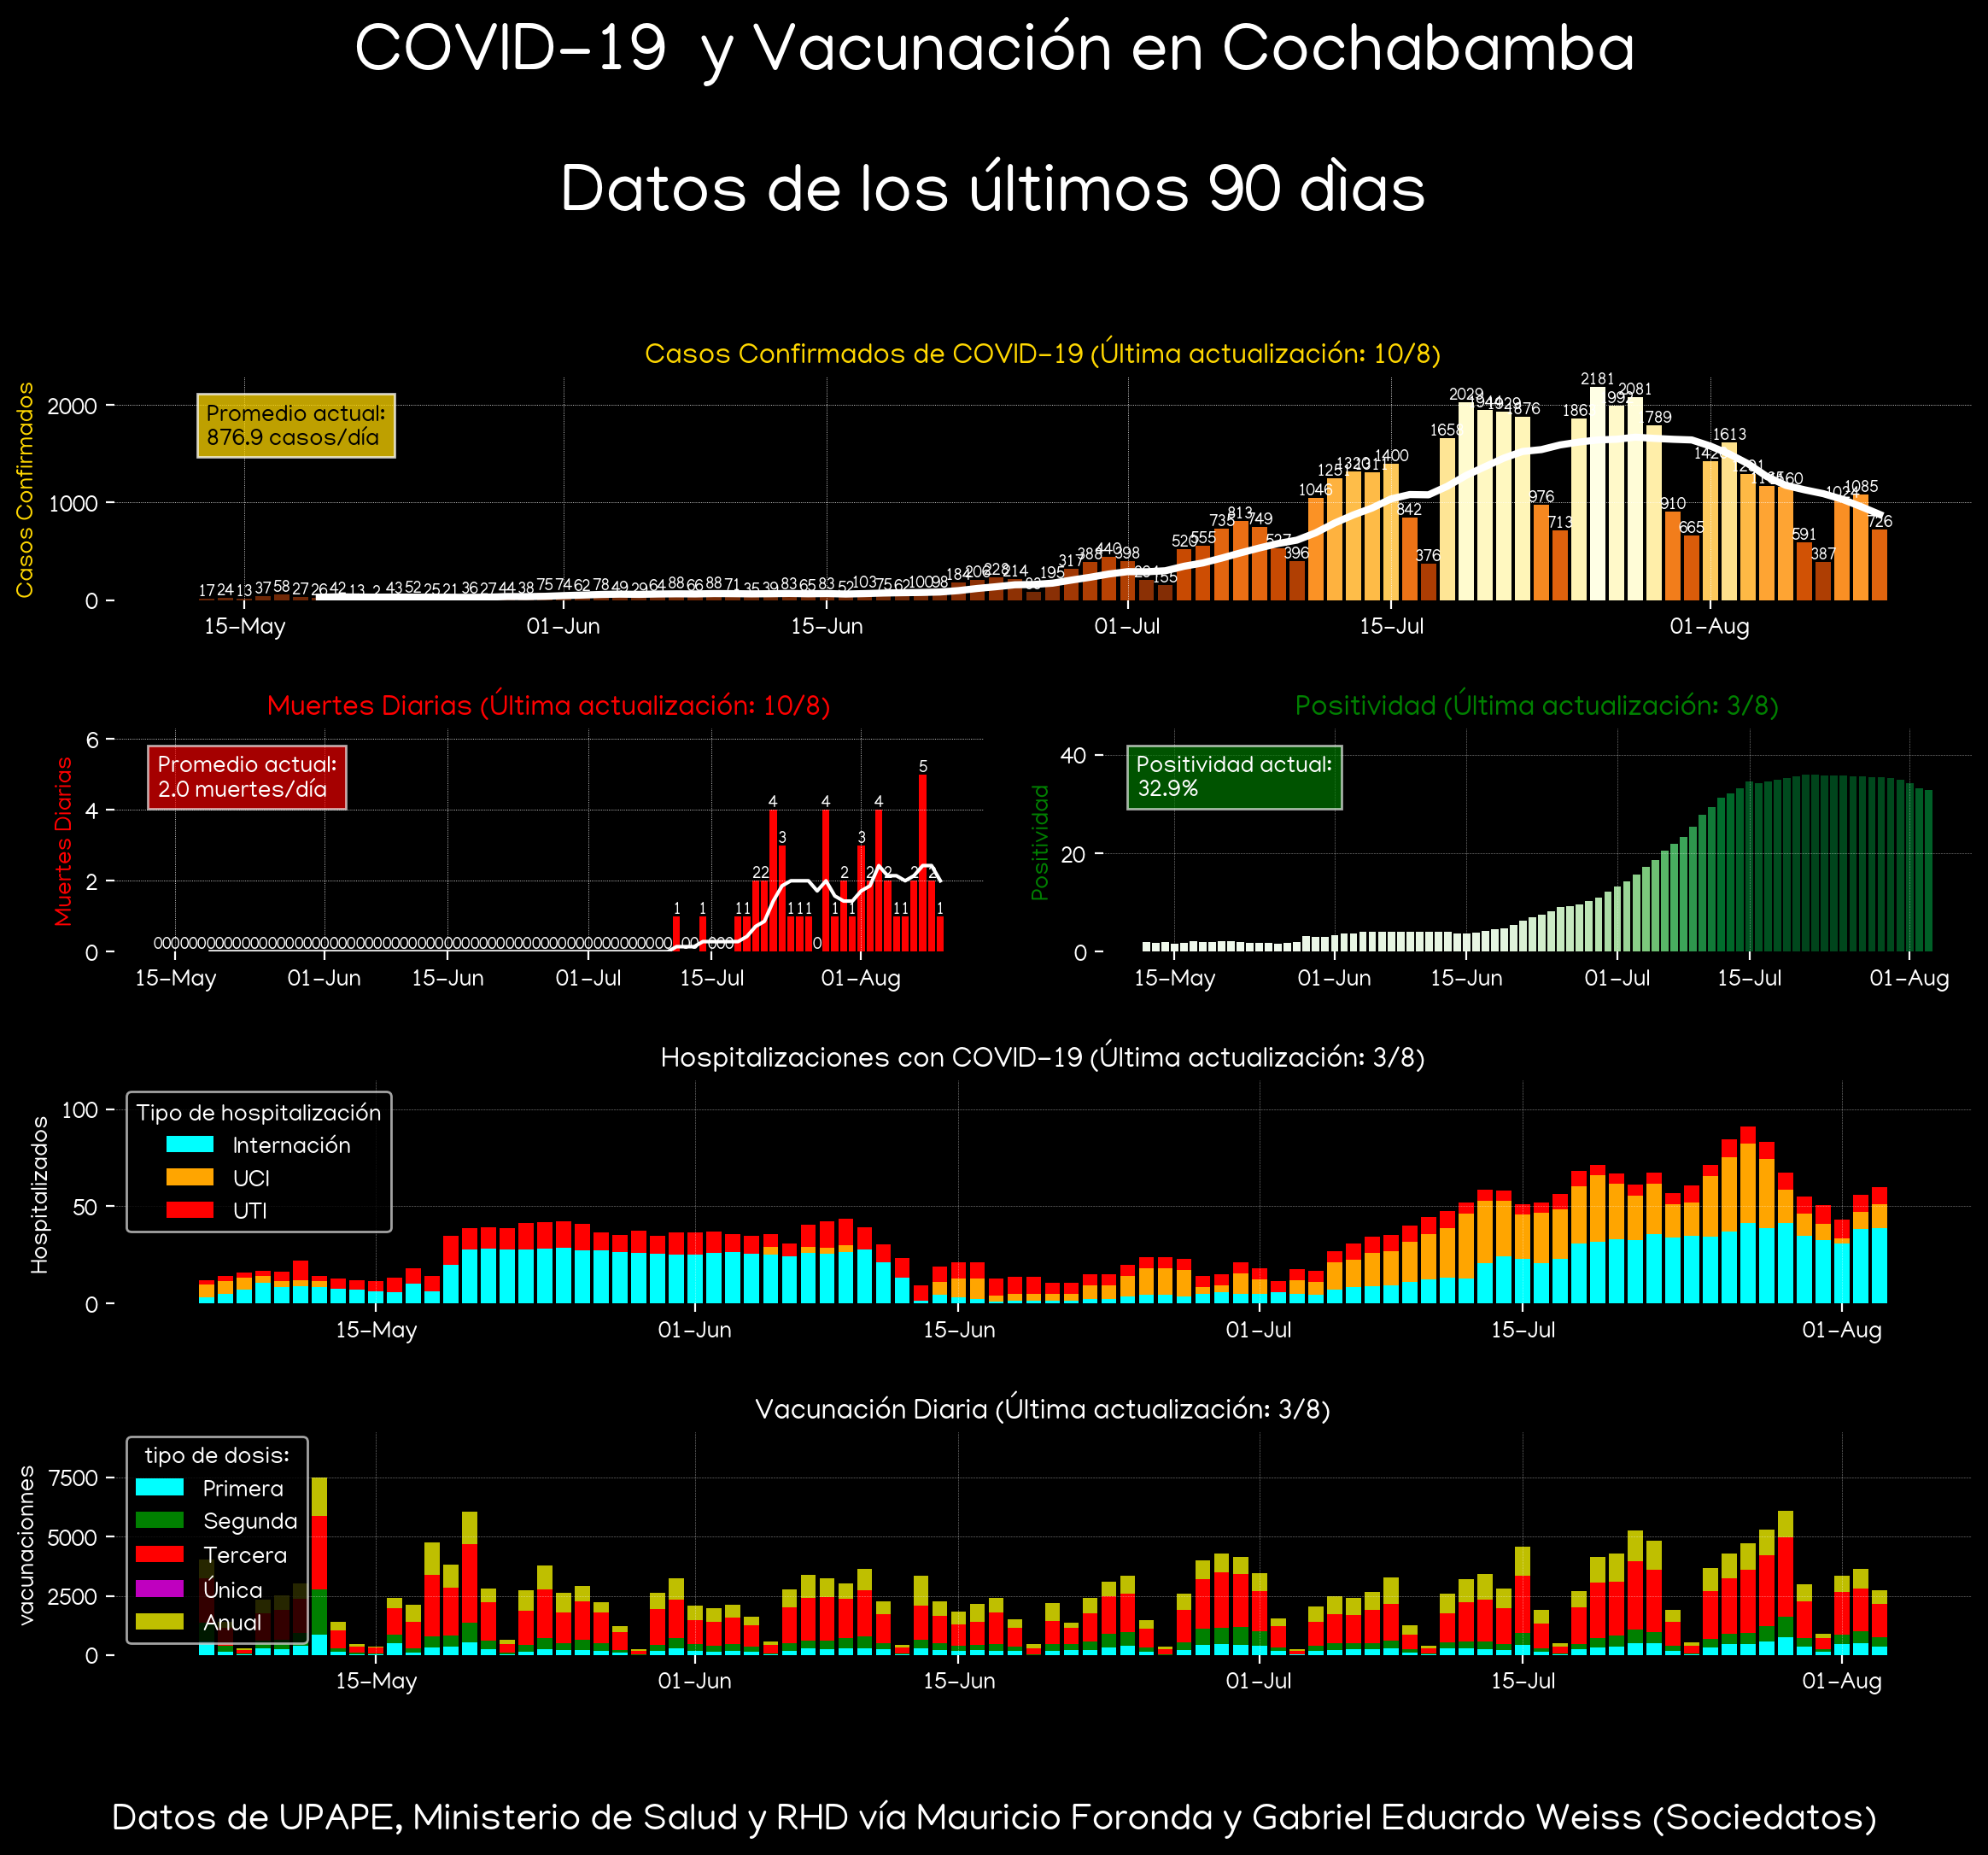

In [14]:
TWEETS_TO_SEND_COUNT = 1

SUCCESS_LIST = []
while SUCCESS_LIST.count(True) < TWEETS_TO_SEND_COUNT:
    
    print("Starting success list", SUCCESS_LIST)

    # 0. Generate message (required, select False for global):
    departamento = random.choice(departamentos)

    # 1. Get the DF:
    message = f"{departamento} covid bolivia" #default: ""
    search_count = 10 # default: 20
    result_type = "mixed" #no default, options: mixed, popular, recent

    # 2. Filter: 
    invalidity_period_days = 10 # default 20
    remove_retweets = True #default: True


    # 3. Select the target tweets by id and count:
    count = TWEETS_TO_SEND_COUNT # no default
    priority = "follower_count" # no defualt, options: "follower_count", "verified" 
    remove_col_value = ["column", "value"] # default: ["column", "value"]
    max_followers = None # default: None

    # 4. Select and save random figures:
    max_count = 4 #default 4
    is_global = False # default False


    ######################################
    #             EXECUTE                #
    ######################################

    MESSAGE = REPLY_MESSAGE_GENERATOR(departamento)
    print("MESSAGE: ", MESSAGE)
    tweet_df = TWEET_FINDER(message, search_count = search_count, result_type = result_type)
    
    if len(tweet_df)==0:
        print(" > empty df: NEXT ITERATION\n")
        continue
        
    tweet_df_filtered = TWEET_FILTER(tweet_df, invalidity_period_days = invalidity_period_days, remove_retweets = remove_retweets)
    SELECTED_TWEETS = TWEET_SELECTOR(tweet_df_filtered, count = count, priority = priority, 
                                    remove_col_value = remove_col_value, 
                                    max_followers = max_followers)
    media_ids = TWEET_IMAGE_SAVER_AND_SELECTOR(departamento)


    SUCCESS_LIST.append(TWEET_REPLIER_AND_LOGGER(SELECTED_TWEETS, MESSAGE, media_ids))

    display(pd.read_csv("id_log.csv"))

    print(f"success list: {SUCCESS_LIST} \n\n\n")

print("\n\n FINISHED WHILE LOOP")